# Metabolomic autoplier analysis 

In [2]:
import os
import autoplier.model as ap
import autoplier.plot as plot

import pandas as pd
import numpy as np

from functools import reduce

from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt


#import csv
#import h5py
#import json
#import mygene
#from onto_lib import general_ontology_tools as got
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import precision_score, recall_score, average_precision_score
#from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import MultiLabelBinarizer
#

# Setup

In [3]:
# seed
seed = 3306059
 
# data path
datadir = os.path.join('data')

#results path
outdir = os.path.join('results')


# Download Data

In [4]:
# - - - - - - Download Data  - - - - - -
#get membership data
membdf=pd.read_csv(os.path.join(datadir, 'membership.csv'), sep=',')
#print(membdf.columns)

#get omics data
omdf=pd.read_csv(os.path.join(datadir, 'Training and validation combined and batch corrected_V3_20190827.csv'), sep=',')
#print(omdf.columns)

#get clinical data
clindf=pd.read_csv(os.path.join(datadir, 'selective clinical data.csv'),index_col='record_id', sep=',')
#print(clindf.columns)


# Sanity Check Data

In [5]:
# - - - - - - Sanity Check Data  - - - - - -
#replace "CACT" to "CACT1"
omdf.replace("CACT", "CACT1", inplace=True)

#make sure we have the correct cohorts named
assert(all(cohort in np.unique(omdf["cohort"]) for cohort in ['EDC', 'FD', 'STENO','CACT1']))

 # Formatting

In [6]:
#Overload paste function to recover original record ids from the cohort and patient ids
def _reduce_concat(x, sep=""):
    return reduce(lambda x, y: str(x) + sep + str(y), x)
def paste(*lists, sep=" ", collapse=None):
    result = map(lambda x: _reduce_concat(x, sep=sep), zip(*lists))
    if collapse is not None:
        return _reduce_concat(result, sep=collapse)
    return list(result)


In [7]:
#merge cohort and patient id to recover record_id used in clinical data
record_ids = paste(np.repeat("JDRF",len(omdf["cohort"])), omdf["cohort"], sep="_")
record_ids = paste(record_ids, omdf["subject_id"], sep="_")
omdf["record_id"] = record_ids

In [8]:
#drop all ambiguous record_ids
omdf.drop_duplicates(subset='record_id', keep=False, inplace=True, ignore_index=False)

In [9]:
#assert there are no duplicated record_ids
dups = omdf.duplicated("record_id")
assert(np.sum(dups)==0)

# Partition Data

In [10]:
#  - - - - - - Partition Data  - - - - - -
#partition observations by subject id
trainrecs = clindf.index[clindf["training_or_validation"]=='training'].to_series()
validrecs = clindf.index[clindf["training_or_validation"]=='validation'].to_series()
allrecs = pd.concat([trainrecs,validrecs])

#get Xtrain and Xvalid
#Xtrain = omdf.loc[omdf["record_id"].isin(trainrecs), : ].set_index(["record_id"])
Xvalid = omdf.loc[omdf["record_id"].isin(validrecs), : ].set_index(["record_id"])
Xtrain = omdf.loc[omdf["record_id"].isin(allrecs), : ].set_index(["record_id"])

#drop uncessary columns
Xtrain.drop(columns=["cohort", "subject_id"], inplace=True)
Xvalid.drop(columns=["cohort", "subject_id"], inplace=True)
#print(Xtrain.columns)
#print(Xvalid.columns)

# - - - - - -  QA/QC  - - - - - -
#remove inf
Xtrain = Xtrain.replace( np.inf , np.nan )
Xvalid = Xvalid.replace( np.inf , np.nan )

#replace NA with half the minimum
Xtrain = Xtrain.replace(np.nan, np.min(Xtrain, axis=0)/2)
Xvalid = Xvalid.replace(np.nan, np.min(Xvalid, axis=0)/2)
#print(Xtrain.isnull().sum())
#print(Xtrain.isnull().sum().sum())

#log2 transform the omics
Xtrain = np.log1p(Xtrain)
Xvalid = np.log1p(Xvalid)

In [13]:
print(Xtrain)

                  2-Ethylhydracrylic acid  2-Hydroxyglutaric acid  \
record_id                                                           
JDRF_CACT1_2450                  1.744761                1.507931   
JDRF_CACT1_1841                  1.988795                1.184899   
JDRF_CACT1_1829                  1.729235                1.677902   
JDRF_CACT1_2052                  1.772245                1.759431   
JDRF_CACT1_2659                  1.548389                1.255848   
...                                   ...                     ...   
JDRF_STENO_16401                 1.739614                1.667222   
JDRF_STENO_16404                 1.521966                1.589400   
JDRF_STENO_16543                 1.396213                1.506714   
JDRF_STENO_16623                 4.891178                4.325262   
JDRF_STENO_16683                 0.909669                1.259097   

                  Oxoglutaric acid  3-Hydroxyisobutyric acid  \
record_id                             

# Omics to pathway transformation

In [11]:
#assert all omics are in the membership data
missingomics =  Xtrain.columns[~(Xtrain.columns.isin(membdf["Standardized.name"])
                                | Xtrain.columns.isin(membdf["Input.name"]))]
if len(missingomics)>0:
    # WARNING: missing omics
    print("the following omics were not found in the membership data.")
    print(missingomics)
assert(len(missingomics)==0)

In [12]:
#get the standardized omics labels for the columns in X
bigomega = [ membdf.loc[membdf["Input.name"] == metabo, "Standardized.name"].iloc[0]
             if metabo in membdf["Input.name"].values else metabo for metabo in Xtrain.columns]
#print(bigomega)

#rename columns of X to the standardized omics labels
Xtrain.columns = bigomega
Xvalid.columns = bigomega
print(bigomega)

['2-Ethylhydracrylic acid', '2-Hydroxyglutaric acid', 'Oxoglutaric acid', '3-Hydroxyisobutyric acid', '3-Hydroxyisovaleric acid', '3-Hydroxy-adipic acid', '3-Hydroxybutyric acid', '3-Hydroxyglutaric acid', '3-Methyladipic acid', '3-Methylcrotonylglycine', '3-Methylglutaconic acid', '4-Hydroxyhippuric acid', 'Hydroxyphenyllactic acid', '4-Aminobutyric acid', 'cis-Aconitic acid', 'Citric acid', 'Ethylmalonic acid', 'Fumaric acid', 'Glycolic acid', 'Hippuric acid', 'Homovanillic acid', 'Isocitric acid', 'Lactic acid', 'Malic acid', 'Methylsuccinic acid', 'N-Acetylaspartic acid', 'N-Acetyltyrosine', 'Succinic acid', 'Tiglylglycine', 'Uracil']


In [14]:
#order membership data by the omics order (columns of X)
Cmat = membdf.set_index("Standardized.name")
Cmat = Cmat.reindex(bigomega).iloc[:, 8:]
print(Cmat)

                          3-Phosphoglycerate dehydrogenase deficiency  \
Standardized.name                                                       
2-Ethylhydracrylic acid                                             0   
2-Hydroxyglutaric acid                                              0   
Oxoglutaric acid                                                    1   
3-Hydroxyisobutyric acid                                            0   
3-Hydroxyisovaleric acid                                            0   
3-Hydroxy-adipic acid                                               0   
3-Hydroxybutyric acid                                               0   
3-Hydroxyglutaric acid                                              0   
3-Methyladipic acid                                                 0   
3-Methylcrotonylglycine                                             0   
3-Methylglutaconic acid                                             0   
4-Hydroxyhippuric acid                             

In [444]:
#get the known pathway and metbolite classes (Pi) order
bigpi = Cmat.columns

#transpose membership matrix so pathways are in rows and omics are in columns
Cmat = Cmat.T
#print(bigpi)

In [445]:
#--- dump formatted xtrain, xvalid, and cmat
Xtrain.to_csv(os.path.join(outdir, 'Xtrain.csv'))
Xvalid.to_csv(os.path.join(outdir, 'Xvalid.csv'))
Cmat.to_csv(os.path.join(outdir, 'Cmat.csv'))
clindf.to_csv(os.path.join(outdir, 'clinical.csv'), index=True)

# Setup Autoplier

In [446]:
#fixed hyperparameters
learning_rate = .001
patience = 20
batch_size= None
maxepoch = 2000
valfrac = .3

In [447]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=patience, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

# Estimate number of latent variables

In [448]:
#  - - - - - - Init guess data compressibility  - - - - - -
# Full dof PCA for all data
pca = PCA(random_state = seed) #do not define number of PCs

#transform omics into pathway representation
Xtilde = np.dot(Xtrain, Cmat.T.to_numpy())

#fit pca on the training data
X_pca = pca.fit_transform(Xtilde)

# compute total variation explained
totvar = sum(pca.explained_variance_)
cum_var = np.cumsum(pca.explained_variance_)/totvar

#show variation explained (diagnostic only)
#nPC = 25
#print(cum_var[0:nPC])

nLV = np.min([len(np.where(cum_var<=.99)[0])*2, len(Cmat.index)])
print(nLV)

20


# Estimate regularization constant

In [451]:
# --- init guess target sparsity based on size LV matrix (bigPI x nLV) ---
# say the LVs are non trivial with 10 major Pathway components in each 
# 1- (nLV * 10) / (nLV * npathways)
target_sparsity = 1 - (10/len(bigpi))
print(len(bigpi))
print(target_sparsity)

186
0.946236559139785


In [452]:
#Optimize regularizaton for given target sparsity
def optimize_l1(target_sparsity, delta, start_l1, X, pathways, n_components):
 
    #initialize values
    ap.set_seed_(seed)
    nrep = 5
    sparsity = np.zeros(nrep)
    mu = np.mean(sparsity)
    #sparsity = 0
    tuning_l1 = start_l1
    step = 10
    closest = 1
    closest_l1 = tuning_l1
    #while abs(sparsity - target_sparsity) > delta:
    while abs(mu - target_sparsity) > delta:

        #reinit sparsity buffer
        sparisity = None
        
        #train model replicates
        for imodel in range(nrep):

            #create model
            mod = ap.autoPLIER(n_components, regval=tuning_l1, learning_rate=learning_rate)

            #set normalizer
            ap.scaler = Normalizer(norm='l1', copy=True)

            #train model
            mod.fit(X, pathways, callbacks, batch_size=batch_size,
                    maxepoch=maxepoch, verbose=0, valfrac=valfrac)

            #compute sparsity :number of elements greater than epsilon(1E-4)
            sparsity[imodel] = ap.sparsity_epsilon(mod.components_decomposition_, 10 ** -4)

        print(sparsity)
        #print mean, std and CV of sparsity
        mu = np.mean(sparsity)
        sigma = np.std(sparsity)
        print(mu, sigma, sigma/mu)
            
        #compute distance to target sparsity
        #diff = sparsity - target_sparsity
        diff = mu - target_sparsity
        
        #update closest sparsity
        if abs(diff) < closest and diff < 0:
            closest = abs(diff)
            closest_l1 = tuning_l1
            #check if diff is still to big else main loop should end
            if abs(diff) > delta:
                tuning_l1 = tuning_l1 * step

        else:

            if diff > 0:
                step = step / 2
                tuning_l1 = closest_l1 * step
            else:
                tuning_l1 = closest_l1 / step
                step = step / 2
                tuning_l1 = tuning_l1 * step
                
        #print(sparsity, diff, closest_l1)
        print(diff, closest_l1)
        
    return closest_l1

In [453]:
# set regularization value to aim for target sparsity
regval = optimize_l1(target_sparsity=target_sparsity, delta=.005, start_l1=1E-5, X=Xtrain, pathways=Cmat, n_components=nLV)

[0.82983871 0.8844086  0.89919355 0.84274194 0.85564516]
0.8623655913978494 0.025808691659052387 0.029927784592167984
-0.08387096774193559 1e-05
[0.83709677 0.92043011 0.93494624 0.92392473 0.89946237]
0.9031720430107526 0.03497947137588211 0.03872957721241784
-0.04306451612903239 0.0001


KeyboardInterrupt: 

In [454]:
regval=1E-3
print(regval)

0.001


# Training

In [455]:
# unsupervised training scheme
def train_autoplier(X, pathways, n_LVs, regval):
    #set seed
    ap.set_seed_(seed)

    #create model
    model = ap.autoPLIER(n_LVs, regval = regval, learning_rate= learning_rate)
    #model = ap.autoPLIER(n_LVs, regval = 0, learning_rate= learning_rate)
    
    #set normalizer
    ap.scaler = Normalizer(norm='l1', copy=True)
    
    #fit model
    model.fit(X, pathways, callbacks, batch_size=batch_size, maxepoch=maxepoch, verbose=0, valfrac=valfrac)
    
    # compute latent variables
    Z = model.transform(X, pathways)
    
    # diagnostic - print sparsity
    print(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4))
    
    #return latent variables and trained model
    return Z, model

In [456]:
Z, model = train_autoplier(Xtrain, Cmat, nLV, regval)
print(Z)

0.9169354838709678
                        0         1    2    3    4    5    6         7   \
record_id                                                                 
JDRF_CACT1_2450   0.711347  0.933507  0.0  0.0  0.0  0.0  0.0  0.498642   
JDRF_CACT1_1841   0.217925  0.291037  0.0  0.0  0.0  0.0  0.0  0.385451   
JDRF_CACT1_1829   0.502179  0.389586  0.0  0.0  0.0  0.0  0.0  0.417915   
JDRF_CACT1_2052   1.056172  0.535797  0.0  0.0  0.0  0.0  0.0  0.389728   
JDRF_CACT1_2659   0.456805  0.372793  0.0  0.0  0.0  0.0  0.0  0.245689   
...                    ...       ...  ...  ...  ...  ...  ...       ...   
JDRF_STENO_16401  0.168750  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
JDRF_STENO_16404  0.534093  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
JDRF_STENO_16543  0.712614  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   
JDRF_STENO_16623  1.887398  4.096256  0.0  0.0  0.0  0.0  0.0  1.428632   
JDRF_STENO_16683  0.235487  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000   

     

# Classifier

In [457]:
def classify(mod, Xtrain, Cmat, clin): 
    #select patients by record_id in the X data
    y = clindf[clindf.index.isin(Xtrain.index)]

    #drop pats with missing outcome
    y = y.loc[~y['rapid_progressor'].isna()]

    #select Xtrain patients with outcomes
    X = Xtrain[Xtrain.index.isin(y.index)]

    #confirm equal number of samples
    assert(len(X.index)==len(y.index))
    
    #encode categorical rapid progressor outcome
    le = LabelEncoder()
    le.fit(y['rapid_progressor'].unique())
    yt = le.transform(y['rapid_progressor'])

    #encode categorical sex clinical variable
    le = LabelEncoder()
    le.fit(y['sex'].unique())
    y['sex'] = le.transform(y['sex'])

    #drop book keeping variables
    y.drop(columns=['internal_id', 
                    'cohort', 
                    'subject_id', 
                    'training_or_validation', 
                    'rapid_progressor',
                    'agtr_inhibitor',
                    'ace_inhibitor',
                    'lipid_lowering_agents'], inplace=True)
    
    #transform Xtrain data into latent representation
    Z = mod.transform(X, Cmat)

    #add clinical variables
    Z.merge(y, on='record_id')
     
    #Latent variable PCA represenation
    pca = PCA(n_components=2, random_state = seed)
    Z_pca = pca.fit_transform(Z)
    
    #visualize case/ctrl patients projected on first 2 prinicpal components
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(Z_pca[:,0], Z_pca[:,1], c = yt)
    plt.show()
    
    PARAMETERS = {
        'C': [
        0.001,
        0.002,
        0.005,
        0.01,
        0.02,
        0.05,
        0.1,
        0.2,
        0.5,
        1.0,
        2.0,
        5.0,
        10.0,
        20.0,
        50.0,    
        100.0,
        200.0,
        500.0,    
        1000.0,
        ]
    }
    MAX_ITER = 200000

    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear',
                                  #class_weight='balanced',
                                  random_state=seed)

    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='f1')
    clf = GridSearchCV(lr_model, PARAMETERS, scoring='roc_auc')
    #clf = GridSearchCV(lr_model, PARAMETERS, scoring='neg_log_loss')
    clf.fit(Z, yt)

    best_params = max(
        zip(
            clf.cv_results_['param_C'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_C = best_params[0]
    print('Mean test scores:')
    print(clf.cv_results_['mean_test_score'])
    print("Best C chosen: ", best_C)
    
    lr_model = LogisticRegression(penalty='l1', 
                                  solver='liblinear', 
                                  #class_weight='balanced',
                                  random_state=seed,
                                  C=best_C)
    lr_model.fit(Z, yt)
    coeffs = lr_model.coef_
    coeffs = coeffs.squeeze()
    print(coeffs)
    
    largest = coeffs.argsort()[-3:]
    smallest = coeffs.argsort()[:3]
    
    largest_vals = [coeffs[x] for x in largest]
    smallest_vals = [coeffs[x] for x in smallest]
    
    print("LVs associated with classification of rapid progressors :" )
    print(largest)
    print(largest_vals)
    for lv in largest:
        plot.plot_top_pathways([lv], 10, (10,5), mod)
        plt.title(f'LV {lv}')
        plt.show()
    
    print("LVs associated with classification of slow progressors :" )
    print(smallest)
    print(smallest_vals)
    for lv in smallest:
        plot.plot_top_pathways([lv], 10, (10,5), mod)
        plt.title(f'LV {lv}')

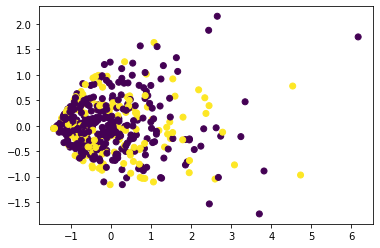

Mean test scores:
[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.44759566 0.50321955 0.50066966 0.49649623 0.49823283
 0.49778224 0.49614253 0.49636323 0.49658181 0.49669286 0.49658357
 0.49669286]
Best C chosen:  0.5
[-0.01315765  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.17723346
  0.          0.          0.         -0.12112924  0.          0.
  0.2364625   0.        ]
LVs associated with classification of rapid progressors :
[19 11 18]
[0.0, 0.17723345906471308, 0.23646250107365904]


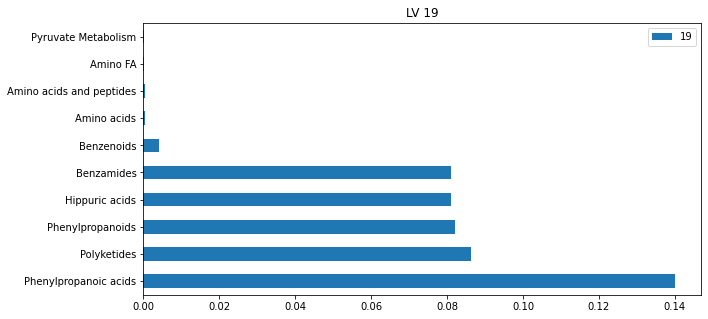

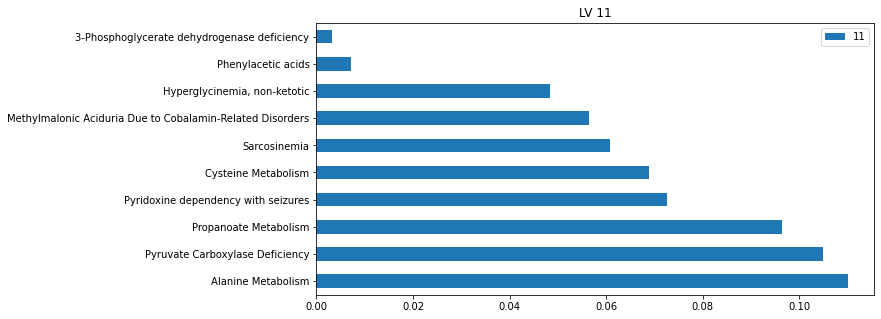

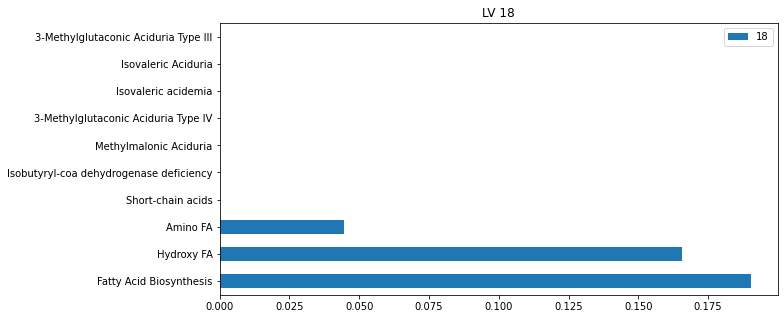

LVs associated with classification of slow progressors :
[15  0 17]
[-0.12112924206705225, -0.013157653784349679, 0.0]


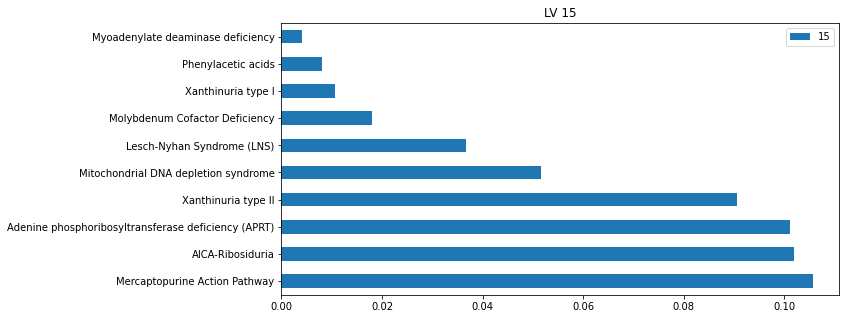

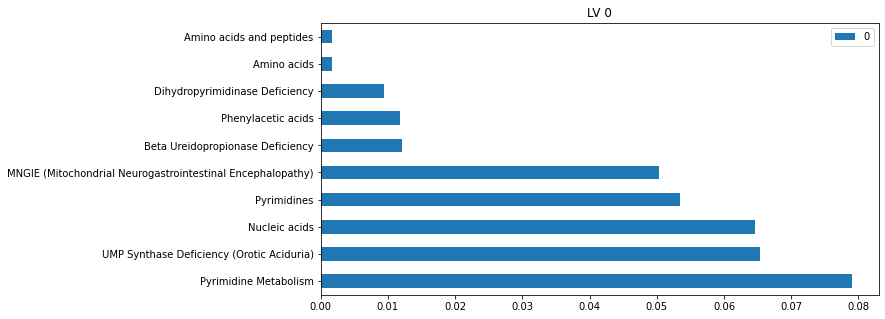

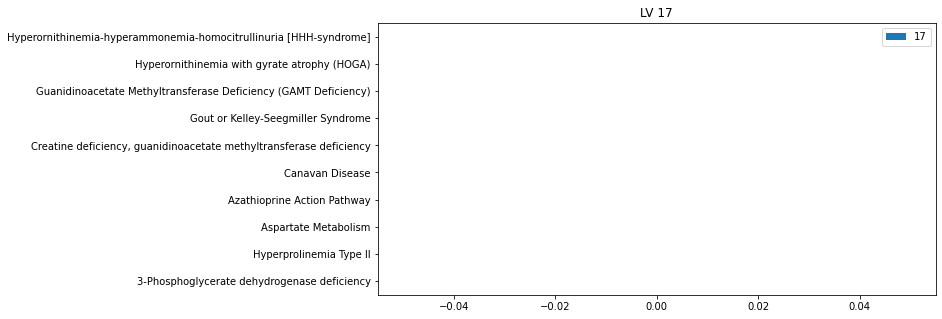

In [458]:
classify(model, Xtrain, Cmat, clindf)